This script implements several ML models and evaluates their performance on the test seasons.

## Import Statements

In [1]:
import random
import pandas as pd
import numpy as np
from tqdm import tqdm
import sqlite3
from matplotlib import pyplot as plt
from datetime import datetime, timedelta
from collections import defaultdict
import seaborn as sns

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import SGDRegressor
from sklearn.linear_model import Ridge
from sklearn.decomposition import PCA
#from sklearn.metrics import r2_score
from sklearn.metrics import f1_score

from xgboost import XGBRegressor
from hyperopt import fmin, hp, tpe, Trials, space_eval, STATUS_OK
from hyperopt.pyll import scope as ho_scope
from hyperopt.pyll.stochastic import sample as ho_sample

import pickle
from IPython.display import clear_output 

## Helper Functions

In [2]:
#convert fractional betting spread strings into floats

def convert_to_float(frac_str):
    try:
        return float(frac_str)
    except ValueError:
        output = frac_str[:-1]
        
        if output=='+':
            return 0.5
        elif output=='-':
            return -0.5
        
        if output[0]=='-':
            output = float(output) - 0.5
        elif output[0]=='+':
            output = float(output) + 0.5
        return output

In [3]:
#evaluate trained model

def eval_winnings(model, X_test, X_test_game_ids, confidence_threshold, bet_amt):
    
    #generate predictions with associated game ids
    predicts_df = pd.DataFrame({'SPREADS_PRED': model.predict(X_test)})
    predicts_df['GAME_ID'] = X_test_game_ids
    
    #create df with predicted spreads, actual spreads, and betting spreads
    winnings_eval_df = test_spreads_df.merge(predicts_df, how='inner', on='GAME_ID')
    winnings_eval_df = winnings_eval_df.merge(spreads_df, how='inner', on=['HOME_TEAM','GM_DATE'])
    
    winnings_eval_df.drop(columns=['SPREAD_1_HOME', 'SPREAD_2_HOME','SPREAD_3_HOME','SPREAD_4_HOME'], inplace=True)
    
    #convert betting spreads to floats
    winnings_eval_df['SPREAD_1_AWAY'] = winnings_eval_df['SPREAD_1_AWAY'].apply(convert_to_float)
    winnings_eval_df['SPREAD_2_AWAY'] = winnings_eval_df['SPREAD_2_AWAY'].apply(convert_to_float)
    winnings_eval_df['SPREAD_3_AWAY'] = winnings_eval_df['SPREAD_3_AWAY'].apply(convert_to_float)
    winnings_eval_df['SPREAD_4_AWAY'] = winnings_eval_df['SPREAD_4_AWAY'].apply(convert_to_float)
    
    #for each game, find betting spread with largest discrepency with predicted spread
    spread_away = np.empty(len(winnings_eval_df))
    odds_away = np.empty(len(winnings_eval_df))
    odds_home = np.empty(len(winnings_eval_df))
    
    for i, row in winnings_eval_df.iterrows():
        
        spread_diff = {}
        
        if not np.isnan(row['SPREAD_1_AWAY']):
            spread_diff['SPREAD_1_AWAY'] = abs(row['SPREAD_1_AWAY'] - row['SPREADS_PRED'])
        if not np.isnan(row['SPREAD_2_AWAY']):
            spread_diff['SPREAD_2_AWAY'] = abs(row['SPREAD_2_AWAY'] - row['SPREADS_PRED'])
        if not np.isnan(row['SPREAD_3_AWAY']):
            spread_diff['SPREAD_3_AWAY'] = abs(row['SPREAD_3_AWAY'] - row['SPREADS_PRED'])
        if not np.isnan(row['SPREAD_4_AWAY']):
            spread_diff['SPREAD_4_AWAY'] = abs(row['SPREAD_4_AWAY'] - row['SPREADS_PRED'])
        
        if not spread_diff:
            continue
            
        book_num = max(spread_diff, key=spread_diff.get)[7]
        
        try:
            spread_away[i] = row['SPREAD_%s_AWAY'%book_num]
            odds_away[i] = row['ODDS_%s_AWAY'%book_num]
            odds_home[i] = row['ODDS_%s_HOME'%book_num]
        except:
            continue
        
    winnings_eval_df.drop(columns=['SPREAD_1_AWAY',
                                   'ODDS_1_AWAY',
                                   'ODDS_1_HOME',
                                   'SPREAD_2_AWAY',
                                   'ODDS_2_AWAY',
                                   'ODDS_2_HOME',
                                   'SPREAD_3_AWAY',
                                   'ODDS_3_AWAY',
                                   'ODDS_3_HOME',
                                   'SPREAD_4_AWAY',
                                   'ODDS_4_AWAY',
                                   'ODDS_4_HOME',], inplace=True)
    
    winnings_eval_df['SPREAD_AWAY'] = spread_away
    winnings_eval_df['ODDS_AWAY'] = odds_away
    winnings_eval_df['ODDS_HOME'] = odds_home
    
    #sort dataframe by date
    winnings_eval_df.sort_values(by='GM_DATE', inplace=True, ignore_index=True)

    #initialize starting bankroll and bet amount
    bankroll = 0
    #bet_amt = 5
    
    bets_placed = 0
    bankroll_trended = np.empty(len(winnings_eval_df))
    bankroll_trended[0] = bankroll
    wins = np.empty(len(winnings_eval_df))
    
    #compute winnings
    for i, row in winnings_eval_df.iterrows():
        
        winnings=0
        
        if abs(row['SPREADS_PRED'] - row['SPREAD_AWAY']) < confidence_threshold:
            if i==0:
                bankroll_trended[i] = bankroll
            else:
                bankroll_trended[i] = bankroll_trended[i-1]
            continue
        
        if row['SPREADS_PRED'] > row['SPREAD_AWAY']:
            bets_placed += 1
            if row['SPREAD'] < row['SPREAD_AWAY']:
                wins[i] = -1
                winnings = -bet_amt
            elif row['SPREAD'] > row['SPREAD_AWAY']:
                wins[i] = 1
                if row['ODDS_HOME'] < 0:
                    winnings = (100 / abs(row['ODDS_HOME'])) * bet_amt
                elif row['ODDS_HOME'] > 0:
                    winnings = (row['ODDS_HOME'] / 100) * bet_amt
                
        elif row['SPREADS_PRED'] < row['SPREAD_AWAY']:
            bets_placed += 1
            if row['SPREAD'] > row['SPREAD_AWAY']:
                wins[i] = -1
                winnings = -bet_amt
            elif row['SPREAD'] < row['SPREAD_AWAY']:
                wins[i] = 1
                if row['ODDS_AWAY'] < 0:
                    winnings = (100 / abs(row['ODDS_AWAY'])) * bet_amt
                elif row['ODDS_AWAY'] > 0:
                    winnings = (row['ODDS_AWAY'] / 100) * bet_amt
        
        bankroll += winnings
        bankroll_trended[i] = bankroll
    
    win_count = (wins==1).sum()
    loss_count = (wins==-1).sum()
    win_pct = win_count / (win_count+loss_count)
    bankroll_trended_df = pd.DataFrame({'date':winnings_eval_df['GM_DATE'], 'bankroll':bankroll_trended})
    bet_pct = bets_placed / winnings_eval_df.shape[0]
    
    if min(bankroll_trended) < 0:
        investment = -min(bankroll_trended) + bet_amt
    else:
        investment = bet_amt
    
    roi = (bankroll - investment) / investment
    
    #plot trended bankroll
    plt.plot(bankroll_trended_df['date'], bankroll_trended_df['bankroll'])
    plt.title('Trended Bankroll')
    plt.xlabel('Date')
    plt.ylabel('Bankroll')
    
    print('Win percentage: ', win_pct)
    print('Percent of bets placed: ', bet_pct)
    print('Profit: ', bankroll)
    print('ROI: ', roi)
    
    
    #return win_pct, bankroll_trended_df, bet_pct


In [4]:
#user specifies a single test season and function returns training data consisting of all seasons prior to the 
#test season as well as test data consisting of the data from the specified season
def get_data(test_season):
    
    #import boxscore data
    df = pd.read_csv('data_v2_0.05.csv')
    df = df[df['SEASON'] <= test_season]
    df.drop(columns=['Unnamed: 0'], inplace=True)
    df.rename(columns={'HOME_TEAM_ID':'TEAM_ID_HOME', 'HOME_TEAM_CITY':'TEAM_CITY_HOME'}, inplace=True)
    
    #create test_spreads_df for model evaluation later
    test_df = df[df['SEASON'] == test_season].copy()
    test_spreads_df = test_df[['GAME_ID','GAME_DATE','TEAM_ID_HOME','TEAM_CITY_HOME','SPREAD']].copy()
    test_spreads_df['TEAM_CITY_HOME'] = test_spreads_df['TEAM_CITY_HOME'].map({'LA':'L.A. Clippers', 
                                                                               'Los Angeles':'L.A. Lakers',
                                                                               'Boston': 'Boston',
                                                                               'Golden State': 'Golden State',
                                                                               'Miami': 'Miami',
                                                                               'Dallas':'Dallas',
                                                                               'Phoenix':'Phoenix',
                                                                               'Milwaukee':'Milwaukee',
                                                                               'Philadelphia':'Philadelphia',
                                                                               'Memphis':'Memphis',
                                                                               'Minnesota':'Minnesota',
                                                                               'Utah':'Utah',
                                                                               'New Orleans':'New Orleans',
                                                                               'Toronto':'Toronto',
                                                                               'Brooklyn':'Brooklyn',
                                                                               'Atlanta':'Atlanta',
                                                                               'Denver':'Denver',
                                                                               'Chicago':'Chicago',
                                                                               'Houston':'Houston',
                                                                               'Portland':'Portland',
                                                                               'Cleveland':'Cleveland',
                                                                               'Charlotte':'Charlotte',
                                                                               'Orlando':'Orlando',
                                                                               'New York':'New York',
                                                                               'San Antonio':'San Antonio',
                                                                               'Washington':'Washington',
                                                                               'Detroit':'Detroit',
                                                                               'Sacramento':'Sacramento',
                                                                               'Oklahoma City':'Oklahoma City',
                                                                               'Indiana':'Indiana'
                                                                              })
    test_spreads_df.rename(columns={'TEAM_CITY_HOME':'HOME_TEAM', 'GAME_DATE':'GM_DATE'}, inplace=True)
    
    #Standardize boxscore data
    df.drop(columns=['TEAM_ID_HOME',
                     'GAME_DATE',
                     'TEAM_CITY_HOME',
                     'SEASON'], inplace=True)

    non_feature_cols = {'GAME_ID', 'SPREAD'}
    feature_cols = set(df.columns) - non_feature_cols

    sclr = StandardScaler()
    df[list(feature_cols)] = sclr.fit_transform(df[list(feature_cols)])
    
    #apply dimensionality reduction to data, keeping n components
    n_components = 20
    pca=PCA(n_components=n_components)
    
    df_ids_spreads = df[list(non_feature_cols)].copy()
    #print(df_ids_spreads)

    df_pca = pd.DataFrame(pca.fit_transform(df[list(feature_cols)]))
    df_pca['GAME_ID'] = np.array(df_ids_spreads['GAME_ID'])
    df_pca['SPREAD'] = np.array(df_ids_spreads['SPREAD'])
    #print(df_pca)
    
    #split pca data into train and test
    test_ids_set = set(test_spreads_df['GAME_ID'])

    train_pca = df_pca[~df_pca['GAME_ID'].isin(test_ids_set)].copy()
    test_pca = df_pca[df_pca['GAME_ID'].isin(test_ids_set)].copy()

    train_game_ids = train_pca['GAME_ID'].copy()
    test_game_ids = test_pca['GAME_ID'].copy()

    y_train_pca = train_pca['SPREAD']
    X_train_pca = train_pca.drop(columns=['SPREAD','GAME_ID'])
    
    #print(y_train_pca)

    y_test_pca = test_pca['SPREAD']
    X_test_pca = test_pca.drop(columns=['SPREAD','GAME_ID'])
    
    return X_train_pca, y_train_pca, X_test_pca, y_test_pca, test_game_ids, test_spreads_df
    

## Data Prep

In [8]:
#import data
df = pd.read_csv('data_elo.csv')
df.rename(columns={'HOME_TEAM_ID':'TEAM_ID_HOME', 'HOME_TEAM_CITY':'TEAM_CITY_HOME'}, inplace=True)
print('Shape: ', df.shape)
df.columns

Shape:  (27363, 52)


Index(['Unnamed: 0', 'TS_PCT', 'PIE', 'REB_PCT', 'PF', 'STL', 'E_PACE', 'WL',
       'FG3M', 'TM_TOV_PCT', 'DEF_RATING', 'BLK', 'REB', 'AST_TOV', 'ELO',
       'E_OFF_RATING', 'FGA', 'EFG_PCT', 'OREB', 'TOV', 'E_TM_TOV_PCT',
       'E_USG_PCT', 'FG3A', 'FTM', 'OREB_PCT', 'FT_PCT', 'FG3_PCT',
       'PACE_PER40', 'DREB', 'PLUS_MINUS', 'E_NET_RATING', 'AST', 'POSS',
       'E_DEF_RATING', 'FGM', 'FG_PCT', 'PACE', 'OFF_RATING', 'FTA', 'PTS',
       'MIN', 'AST_RATIO', 'USG_PCT', 'DREB_PCT', 'AST_PCT', 'NET_RATING',
       'SEASON', 'GAME_DATE', 'GAME_ID', 'TEAM_ID_HOME', 'TEAM_CITY_HOME',
       'SPREAD'],
      dtype='object')

In [9]:
#import betting spreads data for model evaluation
spreads_df = pd.read_csv('spreads_df.csv')
spreads_df.drop(columns=['Unnamed: 0'], inplace=True)

In [10]:
#create test set and create test_spreads_df for model evaluation
test_seasons = ['2021-22', '2020-21', '2019-20', '2018-19', '2017-18']

test_df = df[df['SEASON'].isin(test_seasons)].copy()
test_spreads_df = test_df[['GAME_ID','GAME_DATE','TEAM_ID_HOME','TEAM_CITY_HOME','SPREAD']].copy()
test_spreads_df['TEAM_CITY_HOME'] = test_spreads_df['TEAM_CITY_HOME'].map({'LA':'L.A. Clippers', 
                                                                           'Los Angeles':'L.A. Lakers',
                                                                           'Boston': 'Boston',
                                                                           'Golden State': 'Golden State',
                                                                           'Miami': 'Miami',
                                                                           'Dallas':'Dallas',
                                                                           'Phoenix':'Phoenix',
                                                                           'Milwaukee':'Milwaukee',
                                                                           'Philadelphia':'Philadelphia',
                                                                           'Memphis':'Memphis',
                                                                           'Minnesota':'Minnesota',
                                                                           'Utah':'Utah',
                                                                           'New Orleans':'New Orleans',
                                                                           'Toronto':'Toronto',
                                                                           'Brooklyn':'Brooklyn',
                                                                           'Atlanta':'Atlanta',
                                                                           'Denver':'Denver',
                                                                           'Chicago':'Chicago',
                                                                           'Houston':'Houston',
                                                                           'Portland':'Portland',
                                                                           'Cleveland':'Cleveland',
                                                                           'Charlotte':'Charlotte',
                                                                           'Orlando':'Orlando',
                                                                           'New York':'New York',
                                                                           'San Antonio':'San Antonio',
                                                                           'Washington':'Washington',
                                                                           'Detroit':'Detroit',
                                                                           'Sacramento':'Sacramento',
                                                                           'Oklahoma City':'Oklahoma City',
                                                                           'Indiana':'Indiana'
                                                                          })
test_spreads_df.rename(columns={'TEAM_CITY_HOME':'HOME_TEAM', 'GAME_DATE':'GM_DATE'}, inplace=True)
test_spreads_df.head()

,GAME_ID,GM_DATE,TEAM_ID_HOME,HOME_TEAM,SPREAD
21117,21700001,2017-10-17,1610612739,Cleveland,3.0
21118,21700002,2017-10-17,1610612744,Golden State,-1.0
21119,21700003,2017-10-18,1610612765,Detroit,12.0
21120,21700004,2017-10-18,1610612754,Indiana,9.0
21121,21700005,2017-10-18,1610612753,Orlando,7.0


In [11]:
#Create standardized dataset
df.drop(columns=['Unnamed: 0',
                 'TEAM_ID_HOME',
                 'GAME_DATE',
                 'TEAM_CITY_HOME',
                 'SEASON'], inplace=True)

non_feature_cols = {'GAME_ID', 'SPREAD'}
feature_cols = set(df.columns) - non_feature_cols

#standardize features
sclr = StandardScaler()
df[list(feature_cols)] = sclr.fit_transform(df[list(feature_cols)])
df.head()

,TS_PCT,PIE,REB_PCT,PF,STL,E_PACE,WL,FG3M,TM_TOV_PCT,DEF_RATING,...,FTA,PTS,MIN,AST_RATIO,USG_PCT,DREB_PCT,AST_PCT,NET_RATING,GAME_ID,SPREAD
0,0.904705,1.771392,-0.612333,-0.035506,1.248058,-0.722813,1.512252,0.914586,-1.315327,-1.584155,...,0.504545,0.057281,0.396771,0.572749,0.0,1.049594,0.976413,1.293706,20000711,2.0
1,0.234097,0.262967,1.202120,-1.412543,0.232471,-0.875392,-0.017038,0.235970,1.332182,-0.399166,...,0.766805,-0.546470,-0.230206,-0.801659,0.0,0.586783,-0.502168,0.115668,20000721,21.0
2,0.080330,0.455128,1.645953,-0.669746,-1.037531,0.750482,0.206496,0.112468,0.922484,-0.232907,...,0.029766,0.478955,0.244375,-0.201468,0.0,1.186684,-0.495708,0.250218,20000726,19.0
3,-0.270293,-0.531170,1.289351,0.014785,-0.534899,1.105480,-0.415888,-0.438396,-0.797921,1.659499,...,0.250529,1.308630,-0.386294,1.235569,0.0,0.376730,0.934395,-0.329985,20000729,-7.0
4,0.607966,0.264955,0.847531,-1.423991,-1.306919,-0.076085,0.367178,-0.478126,0.281344,0.711422,...,0.154922,0.549199,-0.483540,0.201983,0.0,-0.638843,-0.327679,0.165131,20000734,-20.0


Text(0, 0.5, 'cumulative explained variance')

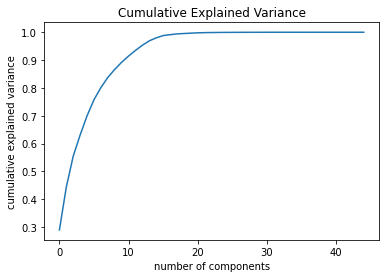

In [12]:
#PCA to minimize multicollinearity
pca = PCA().fit(df[list(feature_cols)])

plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.title('Cumulative Explained Variance')
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')

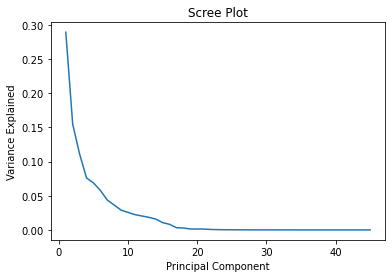

In [11]:
principal_components = np.arange(pca.n_components_)+1
plt.plot(principal_components, pca.explained_variance_ratio_)
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.show()

Looking at the plot above, we can see that most of the explained variance can be explained with 20 principle components.  Therefore, we will reconstruct the data in a 20-dimensional space.

In [12]:
#apply dimensionality reduction to data, keeping n components
n_components = 20
pca=PCA(n_components=n_components)

df_ids_spreads = df[list(non_feature_cols)].copy()

df_pca = pd.DataFrame(pca.fit_transform(df[list(feature_cols)]))
df_pca['GAME_ID'] = df_ids_spreads['GAME_ID']
df_pca['SPREAD'] = df_ids_spreads['SPREAD']
df_pca.head()

,0,1,2,3,4,5,6,7,8,9,...,12,13,14,15,16,17,18,19,GAME_ID,SPREAD
0,-4.191760,-2.608205,1.864478,0.694952,-0.526055,-1.879243,-3.027443,1.164236,-2.581055,0.486824,...,-2.295215,-1.052224,-0.897407,-0.223550,-0.162493,-0.179098,-0.087740,0.307438,20000711,2.0
1,0.920130,-2.146417,-2.458590,1.155902,-1.752429,-0.439910,1.115492,-0.658455,-0.414046,-1.107559,...,-0.301659,-1.536464,-0.904981,0.126223,0.038269,-0.194324,0.244327,-0.063213,20000721,21.0
2,-1.169598,1.460384,-3.122518,-0.731019,0.847428,-0.322921,2.664228,0.339560,0.568556,-0.661272,...,-1.839692,-0.356999,-0.870789,0.032722,-0.583721,-0.005373,0.016921,-0.060991,20000726,19.0
3,-1.349342,3.833427,-0.252943,-3.153443,1.881603,3.830571,1.911361,0.052289,-0.665210,-0.219027,...,0.625347,0.999099,-0.472899,1.071523,-0.027326,0.172346,-0.087367,-0.139239,20000729,-7.0
4,-1.633227,0.285636,-0.704053,-0.547860,-0.779714,1.704825,2.296978,0.533048,1.159765,-0.956665,...,-0.124854,-0.561451,-1.021661,-0.839614,0.257138,0.359876,-0.039135,-0.186703,20000734,-20.0


In [13]:
#split pca data into train and test
test_ids_set = set(test_spreads_df['GAME_ID'])

train_pca = df_pca[~df_pca['GAME_ID'].isin(test_ids_set)].copy()
test_pca = df_pca[df_pca['GAME_ID'].isin(test_ids_set)].copy()

train_game_ids = train_pca['GAME_ID'].copy()
test_game_ids = test_pca['GAME_ID'].copy()

y_train_pca = train_pca['SPREAD']
X_train_pca = train_pca.drop(columns=['SPREAD','GAME_ID'])

y_test_pca = test_pca['SPREAD']
X_test_pca = test_pca.drop(columns=['SPREAD','GAME_ID'])

X_train_pca.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,-4.191760,-2.608205,1.864478,0.694952,-0.526055,-1.879243,-3.027443,1.164236,-2.581055,0.486824,-2.129565,-0.244205,-2.295215,-1.052224,-0.897407,-0.223550,-0.162493,-0.179098,-0.087740,0.307438
1,0.920130,-2.146417,-2.458590,1.155902,-1.752429,-0.439910,1.115492,-0.658455,-0.414046,-1.107559,0.249378,-0.821571,-0.301659,-1.536464,-0.904981,0.126223,0.038269,-0.194324,0.244327,-0.063213
2,-1.169598,1.460384,-3.122518,-0.731019,0.847428,-0.322921,2.664228,0.339560,0.568556,-0.661272,0.403651,-0.248648,-1.839692,-0.356999,-0.870789,0.032722,-0.583721,-0.005373,0.016921,-0.060991
3,-1.349342,3.833427,-0.252943,-3.153443,1.881603,3.830571,1.911361,0.052289,-0.665210,-0.219027,1.271762,0.575203,0.625347,0.999099,-0.472899,1.071523,-0.027326,0.172346,-0.087367,-0.139239
4,-1.633227,0.285636,-0.704053,-0.547860,-0.779714,1.704825,2.296978,0.533048,1.159765,-0.956665,1.130386,0.272306,-0.124854,-0.561451,-1.021661,-0.839614,0.257138,0.359876,-0.039135,-0.186703


## Baseline Model Implementation

In this section, I experiment with several ML models to get a sense of which models seem to be able to extract the most information from our data.

Win percentage:  0.6164383561643836
Percent of bets placed:  0.011872292635969837
Profit:  127.25270542354718
ROI:  3.241756847451573


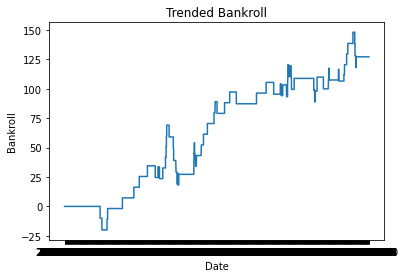

In [14]:
#linear regression
lin_reg = LinearRegression()
lin_reg.fit(X_train_pca, y_train_pca)

eval_winnings(lin_reg, X_test_pca, test_ids_set, confidence_threshold=20, bet_amt=10)

Win percentage:  0.6111111111111112
Percent of bets placed:  0.01459971121450345
Profit:  137.22283529367706
ROI:  3.5740945097892354


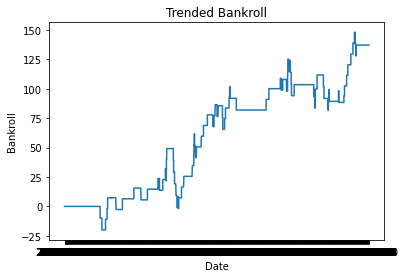

In [15]:
#polynomial regression
#tested with degree=3 as well which yielded poor results
degree = 2
poly=PolynomialFeatures(degree)
X_train_poly = poly.fit_transform(X_train_pca)
X_test_poly = poly.fit_transform(X_test_pca)
poly_reg = LinearRegression()

poly_reg.fit(X_train_poly, y_train_pca)

eval_winnings(poly_reg, X_test_poly, test_ids_set, confidence_threshold=20, bet_amt=10)


Win percentage:  0.514018691588785
Percent of bets placed:  0.03465425958607412
Profit:  -77.86538490162943
ROI:  -1.5714158019383435


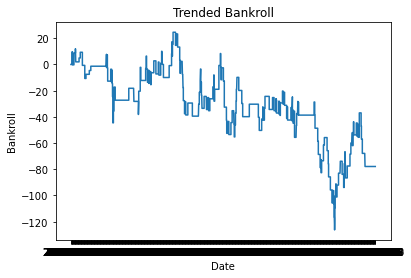

In [19]:
#KNN
knn = KNeighborsRegressor()
knn.fit(X_train_pca, y_train_pca)

eval_winnings(knn, X_test_pca, test_ids_set, confidence_threshold=20, bet_amt=10)

Win percentage:  0.5769230769230769
Percent of bets placed:  0.01283491095780523
Profit:  76.97950174987564
ROI:  0.058468149060790134


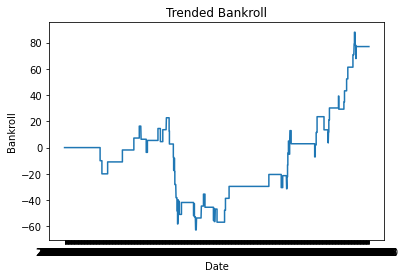

In [17]:
#Random Forrest implementation

rf = RandomForestRegressor()
rf.fit(X_train_pca, y_train_pca)

eval_winnings(rf, X_test_pca, test_ids_set, confidence_threshold=20, bet_amt=10)

Win percentage:  0.5769230769230769
Percent of bets placed:  0.02117760308037863
Profit:  125.30519575805874
ROI:  3.3030971585894298


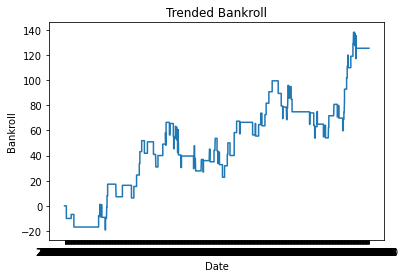

In [18]:
#xgboost
xgb = XGBRegressor()

xgb.fit(X_train_pca, y_train_pca)

eval_winnings(xgb, X_test_pca, test_ids_set, confidence_threshold=20, bet_amt=10)

## Model Tuning

Since linear regression performed best with polynomial features, we will begin by tuning the polynomial regression model by introducing an l2 penalty term.

Win percentage:  0.5934065934065934
Percent of bets placed:  0.014760147601476014
Profit:  117.5180922106731
ROI:  2.91726974035577


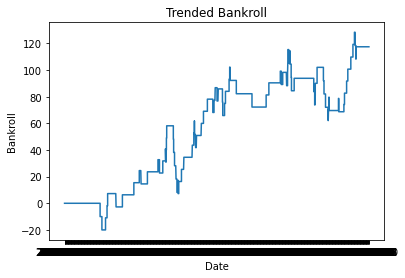

In [32]:
#Ridge Regresssion (Polynomial regression tuning)

#define parameter values to use for tuning
alpha_vals = [100, 10, 1, 0, 0.01, 0.001, 0.0001]
grid = {'alpha': alpha_vals}

#tune using specified hyperparameters
ridge = Ridge()
ridge_grid = GridSearchCV(ridge, grid, cv=5)
ridge_grid.fit(X_train_poly, y_train_pca)

ridge_tuned = ridge_grid.best_estimator_

#evaluate tuned model
eval_winnings(ridge_tuned, X_test_poly, test_ids_set, confidence_threshold=20, bet_amt=10)

In [33]:
ridge_grid.best_params_

{'alpha': 100}

Although the linear and polynomial baseline models appeared to perform best on the test set, there are not many levers to pull with these models when it comes to optimizing performance through hyperparameter tuning.  Therefore, I will focus on tuning the XGBoost model which also recorded strong results on the test set.  I experimented with different hyperparameter spaces to see if I could exceed the ROI's of the linear regression models.

In [25]:
#XGBoost tuning using hyperopt

#define hyperparameter space
hp_space = {'max_depth': hp.quniform('max_depth', 3, 10, 1),
            'eta': hp.uniform('eta', 0.01, 0.5),
            'gamma': hp.uniform('gamma', 0, 20),
            'min_child_weight': hp.quniform('min_child_weight', 0, 10, 1),
            'n_estimators': 100,
            'seed': 3
}

#define objective function
def objective(space):
    clf=XGBRegressor(n_estimators=space['n_estimators'],
                     max_depth = int(space['max_depth']),
                     eta=space['eta'],
                     gamma=space['gamma'],
                     min_child_weight=space['min_child_weight'],
                     seed=space['seed']
                     )
    
    evaluation = [(X_train_pca, y_train_pca),(X_test_pca, y_test_pca)]
    
    clf.fit(X_train_pca, y_train_pca,
           eval_set=evaluation)
    
    cod = clf.score(X_test_pca, y_test_pca)
    
    #since we will minimize this objective function, we will return the negative COD to find the best hyperparameters
    return {'loss': -cod, 'status': STATUS_OK}
    

In [26]:
#search hyperparameter space for values that minimize the objective function
trials = Trials()

best_params = fmin(fn=objective,
                  space=hp_space,
                  algo = tpe.suggest,
                  max_evals = 100,
                  trials=trials)

clear_output()

[0]	validation_0-rmse:13.10811	validation_1-rmse:14.55059
[1]	validation_0-rmse:12.92761	validation_1-rmse:14.47204
[2]	validation_0-rmse:12.75235	validation_1-rmse:14.39093
[3]	validation_0-rmse:12.58649	validation_1-rmse:14.32448
[4]	validation_0-rmse:12.42358	validation_1-rmse:14.26404
[5]	validation_0-rmse:12.27524	validation_1-rmse:14.20947
[6]	validation_0-rmse:12.12992	validation_1-rmse:14.15425
[7]	validation_0-rmse:11.99130	validation_1-rmse:14.10893
[8]	validation_0-rmse:11.86038	validation_1-rmse:14.06656
[9]	validation_0-rmse:11.73134	validation_1-rmse:14.02513
[10]	validation_0-rmse:11.61510	validation_1-rmse:13.99057
[11]	validation_0-rmse:11.49524	validation_1-rmse:13.96235
[12]	validation_0-rmse:11.37964	validation_1-rmse:13.93103
[13]	validation_0-rmse:11.26956	validation_1-rmse:13.91110
[14]	validation_0-rmse:11.17170	validation_1-rmse:13.88706
[15]	validation_0-rmse:11.07615	validation_1-rmse:13.86334
[16]	validation_0-rmse:10.98435	validation_1-rmse:13.84418
[17]	va

[25]	validation_0-rmse:10.36683	validation_1-rmse:13.73828                         
[26]	validation_0-rmse:10.32183	validation_1-rmse:13.73847                         
[27]	validation_0-rmse:10.27812	validation_1-rmse:13.74901                         
[28]	validation_0-rmse:10.25526	validation_1-rmse:13.74973                         
[29]	validation_0-rmse:10.19690	validation_1-rmse:13.75879                         
[30]	validation_0-rmse:10.12863	validation_1-rmse:13.77197                         
[31]	validation_0-rmse:10.10483	validation_1-rmse:13.77322                         
[32]	validation_0-rmse:10.09126	validation_1-rmse:13.77225                         
[33]	validation_0-rmse:10.07021	validation_1-rmse:13.77133                         
[34]	validation_0-rmse:10.06137	validation_1-rmse:13.77673                         
[35]	validation_0-rmse:10.03949	validation_1-rmse:13.78052                         
[36]	validation_0-rmse:10.00001	validation_1-rmse:13.78160                  

[19]	validation_0-rmse:7.33745	validation_1-rmse:14.30471                          
[20]	validation_0-rmse:7.21806	validation_1-rmse:14.32540                          
[21]	validation_0-rmse:7.15601	validation_1-rmse:14.33970                          
[22]	validation_0-rmse:7.13751	validation_1-rmse:14.34228                          
[23]	validation_0-rmse:7.02278	validation_1-rmse:14.35620                          
[24]	validation_0-rmse:6.77559	validation_1-rmse:14.38625                          
[25]	validation_0-rmse:6.50992	validation_1-rmse:14.41658                          
[26]	validation_0-rmse:6.25893	validation_1-rmse:14.42790                          
[27]	validation_0-rmse:6.18545	validation_1-rmse:14.43304                          
[28]	validation_0-rmse:6.12105	validation_1-rmse:14.44174                          
[29]	validation_0-rmse:5.99111	validation_1-rmse:14.46197                          
[30]	validation_0-rmse:5.91996	validation_1-rmse:14.47495                   

[13]	validation_0-rmse:11.40077	validation_1-rmse:13.64307                         
[14]	validation_0-rmse:11.35984	validation_1-rmse:13.63771                         
[15]	validation_0-rmse:11.33157	validation_1-rmse:13.64818                         
[16]	validation_0-rmse:11.31688	validation_1-rmse:13.64798                         
[17]	validation_0-rmse:11.29571	validation_1-rmse:13.64720                         
[18]	validation_0-rmse:11.28054	validation_1-rmse:13.64359                         
[19]	validation_0-rmse:11.26427	validation_1-rmse:13.65000                         
[20]	validation_0-rmse:11.24488	validation_1-rmse:13.64679                         
[21]	validation_0-rmse:11.23106	validation_1-rmse:13.65030                         
[22]	validation_0-rmse:11.21596	validation_1-rmse:13.64981                         
[23]	validation_0-rmse:11.19221	validation_1-rmse:13.65367                         
[24]	validation_0-rmse:11.17722	validation_1-rmse:13.65511                  

[7]	validation_0-rmse:11.74994	validation_1-rmse:13.59301                          
[8]	validation_0-rmse:11.72126	validation_1-rmse:13.59656                          
[9]	validation_0-rmse:11.69500	validation_1-rmse:13.60767                          
[10]	validation_0-rmse:11.66776	validation_1-rmse:13.62116                         
[11]	validation_0-rmse:11.64041	validation_1-rmse:13.62344                         
[12]	validation_0-rmse:11.61539	validation_1-rmse:13.62322                         
[13]	validation_0-rmse:11.59785	validation_1-rmse:13.61925                         
[14]	validation_0-rmse:11.58028	validation_1-rmse:13.62082                         
[15]	validation_0-rmse:11.55963	validation_1-rmse:13.62157                         
[16]	validation_0-rmse:11.54518	validation_1-rmse:13.62031                         
[17]	validation_0-rmse:11.53194	validation_1-rmse:13.61931                         
[18]	validation_0-rmse:11.51402	validation_1-rmse:13.62227                  

[1]	validation_0-rmse:11.74383	validation_1-rmse:13.76906                           
[2]	validation_0-rmse:11.47117	validation_1-rmse:13.70666                           
[3]	validation_0-rmse:11.25610	validation_1-rmse:13.71768                           
[4]	validation_0-rmse:11.13169	validation_1-rmse:13.72308                           
[5]	validation_0-rmse:11.04040	validation_1-rmse:13.73999                           
[6]	validation_0-rmse:10.95646	validation_1-rmse:13.76517                           
[7]	validation_0-rmse:10.85451	validation_1-rmse:13.79170                           
[8]	validation_0-rmse:10.75967	validation_1-rmse:13.80253                           
[9]	validation_0-rmse:10.70702	validation_1-rmse:13.81382                           
[10]	validation_0-rmse:10.64489	validation_1-rmse:13.81402                          
[11]	validation_0-rmse:10.56572	validation_1-rmse:13.82302                          
[12]	validation_0-rmse:10.53034	validation_1-rmse:13.82735       

[93]	validation_0-rmse:10.24585	validation_1-rmse:13.67538                          
[94]	validation_0-rmse:10.24037	validation_1-rmse:13.67701                          
[95]	validation_0-rmse:10.22144	validation_1-rmse:13.67855                          
[96]	validation_0-rmse:10.21324	validation_1-rmse:13.67857                          
[97]	validation_0-rmse:10.21033	validation_1-rmse:13.67935                          
[98]	validation_0-rmse:10.20377	validation_1-rmse:13.67977                          
[99]	validation_0-rmse:10.20065	validation_1-rmse:13.68074                          
[0]	validation_0-rmse:12.49252	validation_1-rmse:14.12730                           
[1]	validation_0-rmse:12.01759	validation_1-rmse:13.86526                           
[2]	validation_0-rmse:11.72742	validation_1-rmse:13.74744                           
[3]	validation_0-rmse:11.51656	validation_1-rmse:13.68314                           
[4]	validation_0-rmse:11.34724	validation_1-rmse:13.67508        

[85]	validation_0-rmse:5.68855	validation_1-rmse:14.33660                           
[86]	validation_0-rmse:5.65892	validation_1-rmse:14.33815                           
[87]	validation_0-rmse:5.63812	validation_1-rmse:14.33557                           
[88]	validation_0-rmse:5.57983	validation_1-rmse:14.34143                           
[89]	validation_0-rmse:5.55291	validation_1-rmse:14.34516                           
[90]	validation_0-rmse:5.51316	validation_1-rmse:14.34793                           
[91]	validation_0-rmse:5.46073	validation_1-rmse:14.35835                           
[92]	validation_0-rmse:5.41144	validation_1-rmse:14.35883                           
[93]	validation_0-rmse:5.33026	validation_1-rmse:14.36384                           
[94]	validation_0-rmse:5.31472	validation_1-rmse:14.36576                           
[95]	validation_0-rmse:5.29907	validation_1-rmse:14.36746                           
[96]	validation_0-rmse:5.23966	validation_1-rmse:14.36942        

[77]	validation_0-rmse:10.59752	validation_1-rmse:13.66743                          
[78]	validation_0-rmse:10.59079	validation_1-rmse:13.66590                          
[79]	validation_0-rmse:10.57727	validation_1-rmse:13.66394                          
[80]	validation_0-rmse:10.55805	validation_1-rmse:13.66264                          
[81]	validation_0-rmse:10.55192	validation_1-rmse:13.66278                          
[82]	validation_0-rmse:10.54681	validation_1-rmse:13.66294                          
[83]	validation_0-rmse:10.54297	validation_1-rmse:13.66364                          
[84]	validation_0-rmse:10.53672	validation_1-rmse:13.66352                          
[85]	validation_0-rmse:10.51825	validation_1-rmse:13.66770                          
[86]	validation_0-rmse:10.50222	validation_1-rmse:13.67205                          
[87]	validation_0-rmse:10.49335	validation_1-rmse:13.67245                          
[88]	validation_0-rmse:10.49017	validation_1-rmse:13.67190       

[69]	validation_0-rmse:7.78327	validation_1-rmse:13.90638                           
[70]	validation_0-rmse:7.77471	validation_1-rmse:13.90826                           
[71]	validation_0-rmse:7.74504	validation_1-rmse:13.90776                           
[72]	validation_0-rmse:7.72976	validation_1-rmse:13.90791                           
[73]	validation_0-rmse:7.72267	validation_1-rmse:13.90753                           
[74]	validation_0-rmse:7.68585	validation_1-rmse:13.91099                           
[75]	validation_0-rmse:7.68146	validation_1-rmse:13.90999                           
[76]	validation_0-rmse:7.67046	validation_1-rmse:13.91340                           
[77]	validation_0-rmse:7.66479	validation_1-rmse:13.91440                           
[78]	validation_0-rmse:7.65942	validation_1-rmse:13.91490                           
[79]	validation_0-rmse:7.63766	validation_1-rmse:13.91612                           
[80]	validation_0-rmse:7.57606	validation_1-rmse:13.92049        

[61]	validation_0-rmse:9.81265	validation_1-rmse:13.69761                           
[62]	validation_0-rmse:9.80819	validation_1-rmse:13.69782                           
[63]	validation_0-rmse:9.79575	validation_1-rmse:13.69777                           
[64]	validation_0-rmse:9.78583	validation_1-rmse:13.69691                           
[65]	validation_0-rmse:9.76867	validation_1-rmse:13.69656                           
[66]	validation_0-rmse:9.75587	validation_1-rmse:13.69793                           
[67]	validation_0-rmse:9.74395	validation_1-rmse:13.69770                           
[68]	validation_0-rmse:9.72088	validation_1-rmse:13.70196                           
[69]	validation_0-rmse:9.71336	validation_1-rmse:13.70187                           
[70]	validation_0-rmse:9.70162	validation_1-rmse:13.70259                           
[71]	validation_0-rmse:9.69846	validation_1-rmse:13.70324                           
[72]	validation_0-rmse:9.68822	validation_1-rmse:13.70275        

[53]	validation_0-rmse:11.68490	validation_1-rmse:13.56534                          
[54]	validation_0-rmse:11.68173	validation_1-rmse:13.56400                          
[55]	validation_0-rmse:11.67718	validation_1-rmse:13.56473                          
[56]	validation_0-rmse:11.67406	validation_1-rmse:13.56517                          
[57]	validation_0-rmse:11.67118	validation_1-rmse:13.56577                          
[58]	validation_0-rmse:11.66711	validation_1-rmse:13.56602                          
[59]	validation_0-rmse:11.66433	validation_1-rmse:13.56647                          
[60]	validation_0-rmse:11.66058	validation_1-rmse:13.56802                          
[61]	validation_0-rmse:11.65797	validation_1-rmse:13.56876                          
[62]	validation_0-rmse:11.65404	validation_1-rmse:13.56963                          
[63]	validation_0-rmse:11.65180	validation_1-rmse:13.56849                          
[64]	validation_0-rmse:11.64861	validation_1-rmse:13.56879       

[45]	validation_0-rmse:12.38903	validation_1-rmse:13.92594                          
[46]	validation_0-rmse:12.37742	validation_1-rmse:13.91786                          
[47]	validation_0-rmse:12.36619	validation_1-rmse:13.90950                          
[48]	validation_0-rmse:12.35500	validation_1-rmse:13.90170                          
[49]	validation_0-rmse:12.34417	validation_1-rmse:13.89375                          
[50]	validation_0-rmse:12.33363	validation_1-rmse:13.88609                          
[51]	validation_0-rmse:12.32313	validation_1-rmse:13.87878                          
[52]	validation_0-rmse:12.31293	validation_1-rmse:13.87087                          
[53]	validation_0-rmse:12.30306	validation_1-rmse:13.86388                          
[54]	validation_0-rmse:12.29318	validation_1-rmse:13.85681                          
[55]	validation_0-rmse:12.28373	validation_1-rmse:13.85038                          
[56]	validation_0-rmse:12.27439	validation_1-rmse:13.84425       

[37]	validation_0-rmse:11.79372	validation_1-rmse:13.57417                          
[38]	validation_0-rmse:11.78861	validation_1-rmse:13.57209                          
[39]	validation_0-rmse:11.78277	validation_1-rmse:13.57405                          
[40]	validation_0-rmse:11.77850	validation_1-rmse:13.57241                          
[41]	validation_0-rmse:11.77286	validation_1-rmse:13.57115                          
[42]	validation_0-rmse:11.76793	validation_1-rmse:13.56940                          
[43]	validation_0-rmse:11.76385	validation_1-rmse:13.56898                          
[44]	validation_0-rmse:11.75945	validation_1-rmse:13.56977                          
[45]	validation_0-rmse:11.75560	validation_1-rmse:13.56863                          
[46]	validation_0-rmse:11.75075	validation_1-rmse:13.56665                          
[47]	validation_0-rmse:11.74640	validation_1-rmse:13.56600                          
[48]	validation_0-rmse:11.74220	validation_1-rmse:13.56550       

[29]	validation_0-rmse:11.96139	validation_1-rmse:13.64000                          
[30]	validation_0-rmse:11.94927	validation_1-rmse:13.63268                          
[31]	validation_0-rmse:11.93807	validation_1-rmse:13.62648                          
[32]	validation_0-rmse:11.92709	validation_1-rmse:13.62245                          
[33]	validation_0-rmse:11.91720	validation_1-rmse:13.61836                          
[34]	validation_0-rmse:11.90732	validation_1-rmse:13.61299                          
[35]	validation_0-rmse:11.89831	validation_1-rmse:13.61004                          
[36]	validation_0-rmse:11.88964	validation_1-rmse:13.60627                          
[37]	validation_0-rmse:11.88106	validation_1-rmse:13.60154                          
[38]	validation_0-rmse:11.87314	validation_1-rmse:13.59944                          
[39]	validation_0-rmse:11.86574	validation_1-rmse:13.59644                          
[40]	validation_0-rmse:11.85838	validation_1-rmse:13.59495       

[21]	validation_0-rmse:11.89276	validation_1-rmse:13.59543                          
[22]	validation_0-rmse:11.88380	validation_1-rmse:13.59222                          
[23]	validation_0-rmse:11.87562	validation_1-rmse:13.58872                          
[24]	validation_0-rmse:11.86632	validation_1-rmse:13.58598                          
[25]	validation_0-rmse:11.85881	validation_1-rmse:13.58459                          
[26]	validation_0-rmse:11.85132	validation_1-rmse:13.58297                          
[27]	validation_0-rmse:11.84428	validation_1-rmse:13.58132                          
[28]	validation_0-rmse:11.83708	validation_1-rmse:13.57813                          
[29]	validation_0-rmse:11.83005	validation_1-rmse:13.57712                          
[30]	validation_0-rmse:11.82366	validation_1-rmse:13.57447                          
[31]	validation_0-rmse:11.81758	validation_1-rmse:13.57530                          
[32]	validation_0-rmse:11.81060	validation_1-rmse:13.57399       

[13]	validation_0-rmse:11.48292	validation_1-rmse:13.60499                          
[14]	validation_0-rmse:11.45651	validation_1-rmse:13.60489                          
[15]	validation_0-rmse:11.43742	validation_1-rmse:13.61574                          
[16]	validation_0-rmse:11.40642	validation_1-rmse:13.61856                          
[17]	validation_0-rmse:11.38684	validation_1-rmse:13.62537                          
[18]	validation_0-rmse:11.36766	validation_1-rmse:13.63231                          
[19]	validation_0-rmse:11.34506	validation_1-rmse:13.63273                          
[20]	validation_0-rmse:11.32482	validation_1-rmse:13.63571                          
[21]	validation_0-rmse:11.30235	validation_1-rmse:13.63296                          
[22]	validation_0-rmse:11.29233	validation_1-rmse:13.63370                          
[23]	validation_0-rmse:11.27320	validation_1-rmse:13.64202                          
[24]	validation_0-rmse:11.24605	validation_1-rmse:13.64210       

[5]	validation_0-rmse:12.51163	validation_1-rmse:14.07997                           
[6]	validation_0-rmse:12.41967	validation_1-rmse:14.01793                           
[7]	validation_0-rmse:12.33699	validation_1-rmse:13.96467                           
[8]	validation_0-rmse:12.26205	validation_1-rmse:13.91921                           
[9]	validation_0-rmse:12.19236	validation_1-rmse:13.87573                           
[10]	validation_0-rmse:12.12992	validation_1-rmse:13.84041                          
[11]	validation_0-rmse:12.07203	validation_1-rmse:13.81029                          
[12]	validation_0-rmse:12.01773	validation_1-rmse:13.78189                          
[13]	validation_0-rmse:11.96747	validation_1-rmse:13.75335                          
[14]	validation_0-rmse:11.92218	validation_1-rmse:13.73028                          
[15]	validation_0-rmse:11.88014	validation_1-rmse:13.71324                          
[16]	validation_0-rmse:11.83871	validation_1-rmse:13.69645       

[97]	validation_0-rmse:10.52411	validation_1-rmse:13.75786                          
[98]	validation_0-rmse:10.50854	validation_1-rmse:13.75593                          
[99]	validation_0-rmse:10.49890	validation_1-rmse:13.75678                          
[0]	validation_0-rmse:12.85293	validation_1-rmse:14.27733                           
[1]	validation_0-rmse:12.55278	validation_1-rmse:14.04122                           
[2]	validation_0-rmse:12.35629	validation_1-rmse:13.89128                           
[3]	validation_0-rmse:12.22001	validation_1-rmse:13.78245                           
[4]	validation_0-rmse:12.12655	validation_1-rmse:13.72008                           
[5]	validation_0-rmse:12.06252	validation_1-rmse:13.68332                           
[6]	validation_0-rmse:12.01519	validation_1-rmse:13.65955                           
[7]	validation_0-rmse:11.97998	validation_1-rmse:13.64086                           
[8]	validation_0-rmse:11.95266	validation_1-rmse:13.62814        

[89]	validation_0-rmse:10.20099	validation_1-rmse:13.76820                          
[90]	validation_0-rmse:10.17799	validation_1-rmse:13.77460                          
[91]	validation_0-rmse:10.17233	validation_1-rmse:13.77812                          
[92]	validation_0-rmse:10.16485	validation_1-rmse:13.77459                          
[93]	validation_0-rmse:10.16086	validation_1-rmse:13.77513                          
[94]	validation_0-rmse:10.15776	validation_1-rmse:13.77474                          
[95]	validation_0-rmse:10.14667	validation_1-rmse:13.77607                          
[96]	validation_0-rmse:10.14208	validation_1-rmse:13.77633                          
[97]	validation_0-rmse:10.12977	validation_1-rmse:13.77871                          
[98]	validation_0-rmse:10.10401	validation_1-rmse:13.78729                          
[99]	validation_0-rmse:10.08359	validation_1-rmse:13.78844                          
[0]	validation_0-rmse:12.95093	validation_1-rmse:14.35886        

[81]	validation_0-rmse:11.90861	validation_1-rmse:13.60311                          
[82]	validation_0-rmse:11.90605	validation_1-rmse:13.60201                          
[83]	validation_0-rmse:11.90346	validation_1-rmse:13.60055                          
[84]	validation_0-rmse:11.90091	validation_1-rmse:13.60029                          
[85]	validation_0-rmse:11.89840	validation_1-rmse:13.59950                          
[86]	validation_0-rmse:11.89604	validation_1-rmse:13.59920                          
[87]	validation_0-rmse:11.89375	validation_1-rmse:13.59840                          
[88]	validation_0-rmse:11.89146	validation_1-rmse:13.59791                          
[89]	validation_0-rmse:11.88925	validation_1-rmse:13.59714                          
[90]	validation_0-rmse:11.88696	validation_1-rmse:13.59694                          
[91]	validation_0-rmse:11.88454	validation_1-rmse:13.59634                          
[92]	validation_0-rmse:11.88223	validation_1-rmse:13.59577       

[73]	validation_0-rmse:3.67304	validation_1-rmse:14.83210                           
[74]	validation_0-rmse:3.58889	validation_1-rmse:14.83274                           
[75]	validation_0-rmse:3.55790	validation_1-rmse:14.83506                           
[76]	validation_0-rmse:3.50675	validation_1-rmse:14.83554                           
[77]	validation_0-rmse:3.47690	validation_1-rmse:14.83802                           
[78]	validation_0-rmse:3.45318	validation_1-rmse:14.84163                           
[79]	validation_0-rmse:3.38579	validation_1-rmse:14.85057                           
[80]	validation_0-rmse:3.34350	validation_1-rmse:14.85239                           
[81]	validation_0-rmse:3.29940	validation_1-rmse:14.85734                           
[82]	validation_0-rmse:3.27295	validation_1-rmse:14.85770                           
[83]	validation_0-rmse:3.25824	validation_1-rmse:14.85759                           
[84]	validation_0-rmse:3.23179	validation_1-rmse:14.86105        

[65]	validation_0-rmse:11.46199	validation_1-rmse:13.59153                          
[66]	validation_0-rmse:11.45649	validation_1-rmse:13.59092                          
[67]	validation_0-rmse:11.45009	validation_1-rmse:13.59363                          
[68]	validation_0-rmse:11.44537	validation_1-rmse:13.59222                          
[69]	validation_0-rmse:11.44167	validation_1-rmse:13.59394                          
[70]	validation_0-rmse:11.43481	validation_1-rmse:13.59493                          
[71]	validation_0-rmse:11.43064	validation_1-rmse:13.59467                          
[72]	validation_0-rmse:11.42682	validation_1-rmse:13.59516                          
[73]	validation_0-rmse:11.42474	validation_1-rmse:13.59539                          
[74]	validation_0-rmse:11.41967	validation_1-rmse:13.59766                          
[75]	validation_0-rmse:11.41696	validation_1-rmse:13.59792                          
[76]	validation_0-rmse:11.41333	validation_1-rmse:13.59825       

[57]	validation_0-rmse:11.01836	validation_1-rmse:13.63685                          
[58]	validation_0-rmse:10.99885	validation_1-rmse:13.63957                          
[59]	validation_0-rmse:10.98294	validation_1-rmse:13.63870                          
[60]	validation_0-rmse:10.97991	validation_1-rmse:13.63953                          
[61]	validation_0-rmse:10.97032	validation_1-rmse:13.63824                          
[62]	validation_0-rmse:10.96723	validation_1-rmse:13.63970                          
[63]	validation_0-rmse:10.96028	validation_1-rmse:13.63916                          
[64]	validation_0-rmse:10.95441	validation_1-rmse:13.64076                          
[65]	validation_0-rmse:10.94889	validation_1-rmse:13.64168                          
[66]	validation_0-rmse:10.92760	validation_1-rmse:13.64549                          
[67]	validation_0-rmse:10.91218	validation_1-rmse:13.64472                          
[68]	validation_0-rmse:10.90785	validation_1-rmse:13.64430       

[49]	validation_0-rmse:9.67573	validation_1-rmse:13.80276                           
[50]	validation_0-rmse:9.66324	validation_1-rmse:13.80586                           
[51]	validation_0-rmse:9.65226	validation_1-rmse:13.80822                           
[52]	validation_0-rmse:9.60236	validation_1-rmse:13.81358                           
[53]	validation_0-rmse:9.54893	validation_1-rmse:13.82958                           
[54]	validation_0-rmse:9.53936	validation_1-rmse:13.82809                           
[55]	validation_0-rmse:9.49903	validation_1-rmse:13.83599                           
[56]	validation_0-rmse:9.49287	validation_1-rmse:13.83630                           
[57]	validation_0-rmse:9.48997	validation_1-rmse:13.83708                           
[58]	validation_0-rmse:9.46984	validation_1-rmse:13.84059                           
[59]	validation_0-rmse:9.44548	validation_1-rmse:13.84460                           
[60]	validation_0-rmse:9.43296	validation_1-rmse:13.84662        

[41]	validation_0-rmse:11.80828	validation_1-rmse:13.57943                          
[42]	validation_0-rmse:11.80293	validation_1-rmse:13.57985                          
[43]	validation_0-rmse:11.79748	validation_1-rmse:13.57846                          
[44]	validation_0-rmse:11.79331	validation_1-rmse:13.57741                          
[45]	validation_0-rmse:11.78791	validation_1-rmse:13.57766                          
[46]	validation_0-rmse:11.78344	validation_1-rmse:13.57831                          
[47]	validation_0-rmse:11.77962	validation_1-rmse:13.57640                          
[48]	validation_0-rmse:11.77583	validation_1-rmse:13.57534                          
[49]	validation_0-rmse:11.77150	validation_1-rmse:13.57501                          
[50]	validation_0-rmse:11.76690	validation_1-rmse:13.57209                          
[51]	validation_0-rmse:11.76268	validation_1-rmse:13.56915                          
[52]	validation_0-rmse:11.75895	validation_1-rmse:13.56847       

[34]	validation_0-rmse:10.71073	validation_1-rmse:13.67545                         
[35]	validation_0-rmse:10.69879	validation_1-rmse:13.67477                         
[36]	validation_0-rmse:10.68293	validation_1-rmse:13.67275                         
[37]	validation_0-rmse:10.67210	validation_1-rmse:13.67477                         
[38]	validation_0-rmse:10.66054	validation_1-rmse:13.67626                         
[39]	validation_0-rmse:10.63708	validation_1-rmse:13.67317                         
[40]	validation_0-rmse:10.63386	validation_1-rmse:13.67459                         
[41]	validation_0-rmse:10.60926	validation_1-rmse:13.67805                         
[42]	validation_0-rmse:10.57777	validation_1-rmse:13.67734                         
[43]	validation_0-rmse:10.53849	validation_1-rmse:13.68047                         
[44]	validation_0-rmse:10.53309	validation_1-rmse:13.68050                         
[45]	validation_0-rmse:10.52213	validation_1-rmse:13.68076                  

[28]	validation_0-rmse:11.49958	validation_1-rmse:13.57696                         
[29]	validation_0-rmse:11.48995	validation_1-rmse:13.57772                         
[30]	validation_0-rmse:11.48334	validation_1-rmse:13.57805                         
[31]	validation_0-rmse:11.47341	validation_1-rmse:13.57659                         
[32]	validation_0-rmse:11.46402	validation_1-rmse:13.57739                         
[33]	validation_0-rmse:11.44733	validation_1-rmse:13.58233                         
[34]	validation_0-rmse:11.44239	validation_1-rmse:13.58360                         
[35]	validation_0-rmse:11.43562	validation_1-rmse:13.58593                         
[36]	validation_0-rmse:11.42854	validation_1-rmse:13.58650                         
[37]	validation_0-rmse:11.41657	validation_1-rmse:13.58954                         
[38]	validation_0-rmse:11.40546	validation_1-rmse:13.58844                         
[39]	validation_0-rmse:11.40095	validation_1-rmse:13.58723                  

[22]	validation_0-rmse:10.11115	validation_1-rmse:13.68098                         
[23]	validation_0-rmse:10.05579	validation_1-rmse:13.68860                         
[24]	validation_0-rmse:10.01840	validation_1-rmse:13.69229                         
[25]	validation_0-rmse:9.98037	validation_1-rmse:13.69644                          
[26]	validation_0-rmse:9.95207	validation_1-rmse:13.69990                          
[27]	validation_0-rmse:9.92727	validation_1-rmse:13.70412                          
[28]	validation_0-rmse:9.91442	validation_1-rmse:13.70384                          
[29]	validation_0-rmse:9.88837	validation_1-rmse:13.70698                          
[30]	validation_0-rmse:9.86931	validation_1-rmse:13.70847                          
[31]	validation_0-rmse:9.82757	validation_1-rmse:13.71819                          
[32]	validation_0-rmse:9.78273	validation_1-rmse:13.72296                          
[33]	validation_0-rmse:9.76971	validation_1-rmse:13.72453                   

[16]	validation_0-rmse:8.27492	validation_1-rmse:13.98275                          
[17]	validation_0-rmse:8.11580	validation_1-rmse:13.98495                          
[18]	validation_0-rmse:8.05408	validation_1-rmse:13.98949                          
[19]	validation_0-rmse:7.95387	validation_1-rmse:14.00687                          
[20]	validation_0-rmse:7.86004	validation_1-rmse:14.00702                          
[21]	validation_0-rmse:7.80349	validation_1-rmse:14.00953                          
[22]	validation_0-rmse:7.67043	validation_1-rmse:14.01902                          
[23]	validation_0-rmse:7.48638	validation_1-rmse:14.03747                          
[24]	validation_0-rmse:7.41897	validation_1-rmse:14.04339                          
[25]	validation_0-rmse:7.32692	validation_1-rmse:14.05187                          
[26]	validation_0-rmse:7.24542	validation_1-rmse:14.05841                          
[27]	validation_0-rmse:7.17291	validation_1-rmse:14.05950                   

[10]	validation_0-rmse:12.35864	validation_1-rmse:13.89320                         
[11]	validation_0-rmse:12.31565	validation_1-rmse:13.85930                         
[12]	validation_0-rmse:12.27668	validation_1-rmse:13.83098                         
[13]	validation_0-rmse:12.24197	validation_1-rmse:13.80612                         
[14]	validation_0-rmse:12.21098	validation_1-rmse:13.78523                         
[15]	validation_0-rmse:12.18267	validation_1-rmse:13.76363                         
[16]	validation_0-rmse:12.15712	validation_1-rmse:13.74468                         
[17]	validation_0-rmse:12.13429	validation_1-rmse:13.73020                         
[18]	validation_0-rmse:12.11323	validation_1-rmse:13.71446                         
[19]	validation_0-rmse:12.09386	validation_1-rmse:13.70237                         
[20]	validation_0-rmse:12.07649	validation_1-rmse:13.69120                         
[21]	validation_0-rmse:12.06057	validation_1-rmse:13.68029                  

[4]	validation_0-rmse:11.41951	validation_1-rmse:13.66867                          
[5]	validation_0-rmse:11.32579	validation_1-rmse:13.68912                          
[6]	validation_0-rmse:11.23153	validation_1-rmse:13.70977                          
[7]	validation_0-rmse:11.18092	validation_1-rmse:13.72761                          
[8]	validation_0-rmse:11.12340	validation_1-rmse:13.74609                          
[9]	validation_0-rmse:11.07002	validation_1-rmse:13.76959                          
[10]	validation_0-rmse:11.04377	validation_1-rmse:13.76871                         
[11]	validation_0-rmse:10.99582	validation_1-rmse:13.78549                         
[12]	validation_0-rmse:10.92536	validation_1-rmse:13.79876                         
[13]	validation_0-rmse:10.87804	validation_1-rmse:13.81716                         
[14]	validation_0-rmse:10.86155	validation_1-rmse:13.82109                         
[15]	validation_0-rmse:10.79673	validation_1-rmse:13.84852                  

[98]	validation_0-rmse:11.79169	validation_1-rmse:13.57559                         
[99]	validation_0-rmse:11.78960	validation_1-rmse:13.57605                         
[0]	validation_0-rmse:12.89366	validation_1-rmse:14.37327                          
[1]	validation_0-rmse:12.56938	validation_1-rmse:14.17242                          
[2]	validation_0-rmse:12.30913	validation_1-rmse:14.01961                          
[3]	validation_0-rmse:12.09654	validation_1-rmse:13.90234                          
[4]	validation_0-rmse:11.91957	validation_1-rmse:13.81434                          
[5]	validation_0-rmse:11.78172	validation_1-rmse:13.75678                          
[6]	validation_0-rmse:11.65481	validation_1-rmse:13.70722                          
[7]	validation_0-rmse:11.55142	validation_1-rmse:13.67987                          
[8]	validation_0-rmse:11.45934	validation_1-rmse:13.65894                          
[9]	validation_0-rmse:11.37154	validation_1-rmse:13.65207                   

[92]	validation_0-rmse:10.64629	validation_1-rmse:13.75854                         
[93]	validation_0-rmse:10.63467	validation_1-rmse:13.76245                         
[94]	validation_0-rmse:10.62212	validation_1-rmse:13.76357                         
[95]	validation_0-rmse:10.60874	validation_1-rmse:13.76509                         
[96]	validation_0-rmse:10.59927	validation_1-rmse:13.76723                         
[97]	validation_0-rmse:10.58821	validation_1-rmse:13.77148                         
[98]	validation_0-rmse:10.57503	validation_1-rmse:13.77764                         
[99]	validation_0-rmse:10.56183	validation_1-rmse:13.78321                         
[0]	validation_0-rmse:13.25594	validation_1-rmse:14.60411                          
[1]	validation_0-rmse:13.21189	validation_1-rmse:14.56880                          
[2]	validation_0-rmse:13.16941	validation_1-rmse:14.53482                          
[3]	validation_0-rmse:13.12805	validation_1-rmse:14.50107                   

[86]	validation_0-rmse:11.72030	validation_1-rmse:13.56560                         
[87]	validation_0-rmse:11.71798	validation_1-rmse:13.56592                         
[88]	validation_0-rmse:11.71587	validation_1-rmse:13.56654                         
[89]	validation_0-rmse:11.71396	validation_1-rmse:13.56638                         
[90]	validation_0-rmse:11.71182	validation_1-rmse:13.56615                         
[91]	validation_0-rmse:11.70998	validation_1-rmse:13.56590                         
[92]	validation_0-rmse:11.70759	validation_1-rmse:13.56591                         
[93]	validation_0-rmse:11.70529	validation_1-rmse:13.56571                         
[94]	validation_0-rmse:11.70307	validation_1-rmse:13.56591                         
[95]	validation_0-rmse:11.70142	validation_1-rmse:13.56577                         
[96]	validation_0-rmse:11.69917	validation_1-rmse:13.56572                         
[97]	validation_0-rmse:11.69716	validation_1-rmse:13.56590                  

[80]	validation_0-rmse:11.65128	validation_1-rmse:13.57099                         
[81]	validation_0-rmse:11.64807	validation_1-rmse:13.57060                         
[82]	validation_0-rmse:11.64418	validation_1-rmse:13.57045                         
[83]	validation_0-rmse:11.64096	validation_1-rmse:13.57135                         
[84]	validation_0-rmse:11.63766	validation_1-rmse:13.57134                         
[85]	validation_0-rmse:11.63374	validation_1-rmse:13.57044                         
[86]	validation_0-rmse:11.63046	validation_1-rmse:13.57212                         
[87]	validation_0-rmse:11.62792	validation_1-rmse:13.57269                         
[88]	validation_0-rmse:11.62499	validation_1-rmse:13.57279                         
[89]	validation_0-rmse:11.62148	validation_1-rmse:13.57289                         
[90]	validation_0-rmse:11.61870	validation_1-rmse:13.57270                         
[91]	validation_0-rmse:11.61514	validation_1-rmse:13.57215                  

[74]	validation_0-rmse:11.53323	validation_1-rmse:13.57214                         
[75]	validation_0-rmse:11.53011	validation_1-rmse:13.57251                         
[76]	validation_0-rmse:11.52482	validation_1-rmse:13.57176                         
[77]	validation_0-rmse:11.52036	validation_1-rmse:13.57138                         
[78]	validation_0-rmse:11.51708	validation_1-rmse:13.57258                         
[79]	validation_0-rmse:11.51367	validation_1-rmse:13.57352                         
[80]	validation_0-rmse:11.51133	validation_1-rmse:13.57393                         
[81]	validation_0-rmse:11.50854	validation_1-rmse:13.57410                         
[82]	validation_0-rmse:11.50430	validation_1-rmse:13.57619                         
[83]	validation_0-rmse:11.50115	validation_1-rmse:13.57677                         
[84]	validation_0-rmse:11.49835	validation_1-rmse:13.57703                         
[85]	validation_0-rmse:11.49511	validation_1-rmse:13.57693                  

[68]	validation_0-rmse:10.91446	validation_1-rmse:13.65735                         
[69]	validation_0-rmse:10.91266	validation_1-rmse:13.65756                         
[70]	validation_0-rmse:10.90706	validation_1-rmse:13.65772                         
[71]	validation_0-rmse:10.90342	validation_1-rmse:13.65660                         
[72]	validation_0-rmse:10.89490	validation_1-rmse:13.65632                         
[73]	validation_0-rmse:10.88990	validation_1-rmse:13.65796                         
[74]	validation_0-rmse:10.88634	validation_1-rmse:13.65640                         
[75]	validation_0-rmse:10.86806	validation_1-rmse:13.65837                         
[76]	validation_0-rmse:10.86170	validation_1-rmse:13.65908                         
[77]	validation_0-rmse:10.85396	validation_1-rmse:13.65969                         
[78]	validation_0-rmse:10.85010	validation_1-rmse:13.65979                         
[79]	validation_0-rmse:10.84217	validation_1-rmse:13.66018                  

[62]	validation_0-rmse:11.83993	validation_1-rmse:13.58650                         
[63]	validation_0-rmse:11.83675	validation_1-rmse:13.58589                         
[64]	validation_0-rmse:11.83384	validation_1-rmse:13.58550                         
[65]	validation_0-rmse:11.83059	validation_1-rmse:13.58388                         
[66]	validation_0-rmse:11.82735	validation_1-rmse:13.58251                         
[67]	validation_0-rmse:11.82433	validation_1-rmse:13.58214                         
[68]	validation_0-rmse:11.82169	validation_1-rmse:13.58210                         
[69]	validation_0-rmse:11.81864	validation_1-rmse:13.58221                         
[70]	validation_0-rmse:11.81568	validation_1-rmse:13.58203                         
[71]	validation_0-rmse:11.81289	validation_1-rmse:13.58140                         
[72]	validation_0-rmse:11.81018	validation_1-rmse:13.58130                         
[73]	validation_0-rmse:11.80742	validation_1-rmse:13.58187                  

[56]	validation_0-rmse:11.29900	validation_1-rmse:13.58858                         
[57]	validation_0-rmse:11.29051	validation_1-rmse:13.58863                         
[58]	validation_0-rmse:11.28255	validation_1-rmse:13.58879                         
[59]	validation_0-rmse:11.27762	validation_1-rmse:13.58939                         
[60]	validation_0-rmse:11.27188	validation_1-rmse:13.58954                         
[61]	validation_0-rmse:11.26614	validation_1-rmse:13.58943                         
[62]	validation_0-rmse:11.25671	validation_1-rmse:13.58778                         
[63]	validation_0-rmse:11.25167	validation_1-rmse:13.58659                         
[64]	validation_0-rmse:11.24765	validation_1-rmse:13.58748                         
[65]	validation_0-rmse:11.24104	validation_1-rmse:13.58861                         
[66]	validation_0-rmse:11.23696	validation_1-rmse:13.58960                         
[67]	validation_0-rmse:11.23018	validation_1-rmse:13.58945                  

[50]	validation_0-rmse:11.84557	validation_1-rmse:13.58403                         
[51]	validation_0-rmse:11.84158	validation_1-rmse:13.58411                         
[52]	validation_0-rmse:11.83758	validation_1-rmse:13.58385                         
[53]	validation_0-rmse:11.83390	validation_1-rmse:13.58238                         
[54]	validation_0-rmse:11.83035	validation_1-rmse:13.58203                         
[55]	validation_0-rmse:11.82650	validation_1-rmse:13.58089                         
[56]	validation_0-rmse:11.82297	validation_1-rmse:13.58118                         
[57]	validation_0-rmse:11.81950	validation_1-rmse:13.58102                         
[58]	validation_0-rmse:11.81551	validation_1-rmse:13.57902                         
[59]	validation_0-rmse:11.81215	validation_1-rmse:13.57853                         
[60]	validation_0-rmse:11.80880	validation_1-rmse:13.57894                         
[61]	validation_0-rmse:11.80609	validation_1-rmse:13.57890                  

[44]	validation_0-rmse:11.76762	validation_1-rmse:13.58166                         
[45]	validation_0-rmse:11.76313	validation_1-rmse:13.58051                         
[46]	validation_0-rmse:11.75894	validation_1-rmse:13.58031                         
[47]	validation_0-rmse:11.75534	validation_1-rmse:13.58081                         
[48]	validation_0-rmse:11.75111	validation_1-rmse:13.58030                         
[49]	validation_0-rmse:11.74638	validation_1-rmse:13.57820                         
[50]	validation_0-rmse:11.74222	validation_1-rmse:13.57789                         
[51]	validation_0-rmse:11.73865	validation_1-rmse:13.57613                         
[52]	validation_0-rmse:11.73487	validation_1-rmse:13.57786                         
[53]	validation_0-rmse:11.73123	validation_1-rmse:13.57527                         
[54]	validation_0-rmse:11.72728	validation_1-rmse:13.57445                         
[55]	validation_0-rmse:11.72306	validation_1-rmse:13.57432                  

[38]	validation_0-rmse:12.44766	validation_1-rmse:14.03476                         
[39]	validation_0-rmse:12.43226	validation_1-rmse:14.02443                         
[40]	validation_0-rmse:12.41714	validation_1-rmse:14.01484                         
[41]	validation_0-rmse:12.40229	validation_1-rmse:14.00553                         
[42]	validation_0-rmse:12.38765	validation_1-rmse:13.99610                         
[43]	validation_0-rmse:12.37345	validation_1-rmse:13.98742                         
[44]	validation_0-rmse:12.35925	validation_1-rmse:13.97858                         
[45]	validation_0-rmse:12.34524	validation_1-rmse:13.96981                         
[46]	validation_0-rmse:12.33150	validation_1-rmse:13.96123                         
[47]	validation_0-rmse:12.31817	validation_1-rmse:13.95324                         
[48]	validation_0-rmse:12.30490	validation_1-rmse:13.94506                         
[49]	validation_0-rmse:12.29205	validation_1-rmse:13.93778                  

[32]	validation_0-rmse:11.34968	validation_1-rmse:13.58700                         
[33]	validation_0-rmse:11.33865	validation_1-rmse:13.58842                         
[34]	validation_0-rmse:11.32895	validation_1-rmse:13.58819                         
[35]	validation_0-rmse:11.31758	validation_1-rmse:13.59155                         
[36]	validation_0-rmse:11.30652	validation_1-rmse:13.59298                         
[37]	validation_0-rmse:11.29384	validation_1-rmse:13.59017                         
[38]	validation_0-rmse:11.27740	validation_1-rmse:13.59114                         
[39]	validation_0-rmse:11.26582	validation_1-rmse:13.59037                         
[40]	validation_0-rmse:11.26002	validation_1-rmse:13.59189                         
[41]	validation_0-rmse:11.25104	validation_1-rmse:13.59392                         
[42]	validation_0-rmse:11.24059	validation_1-rmse:13.59276                         
[43]	validation_0-rmse:11.23034	validation_1-rmse:13.59597                  

[26]	validation_0-rmse:8.83277	validation_1-rmse:13.89694                          
[27]	validation_0-rmse:8.82303	validation_1-rmse:13.89799                          
[28]	validation_0-rmse:8.80238	validation_1-rmse:13.90168                          
[29]	validation_0-rmse:8.78503	validation_1-rmse:13.89949                          
[30]	validation_0-rmse:8.76671	validation_1-rmse:13.89873                          
[31]	validation_0-rmse:8.66702	validation_1-rmse:13.90338                          
[32]	validation_0-rmse:8.65198	validation_1-rmse:13.90193                          
[33]	validation_0-rmse:8.63537	validation_1-rmse:13.90148                          
[34]	validation_0-rmse:8.61363	validation_1-rmse:13.90216                          
[35]	validation_0-rmse:8.58113	validation_1-rmse:13.91322                          
[36]	validation_0-rmse:8.49128	validation_1-rmse:13.91297                          
[37]	validation_0-rmse:8.45962	validation_1-rmse:13.91384                   

[20]	validation_0-rmse:11.89899	validation_1-rmse:13.59902                         
[21]	validation_0-rmse:11.88955	validation_1-rmse:13.59792                         
[22]	validation_0-rmse:11.88036	validation_1-rmse:13.59147                         
[23]	validation_0-rmse:11.87206	validation_1-rmse:13.58999                         
[24]	validation_0-rmse:11.86415	validation_1-rmse:13.58858                         
[25]	validation_0-rmse:11.85672	validation_1-rmse:13.58704                         
[26]	validation_0-rmse:11.84839	validation_1-rmse:13.58605                         
[27]	validation_0-rmse:11.84159	validation_1-rmse:13.58360                         
[28]	validation_0-rmse:11.83397	validation_1-rmse:13.58150                         
[29]	validation_0-rmse:11.82716	validation_1-rmse:13.58120                         
[30]	validation_0-rmse:11.82077	validation_1-rmse:13.57933                         
[31]	validation_0-rmse:11.81445	validation_1-rmse:13.57647                  

[14]	validation_0-rmse:10.05301	validation_1-rmse:13.75824                         
[15]	validation_0-rmse:10.03209	validation_1-rmse:13.75757                         
[16]	validation_0-rmse:9.97487	validation_1-rmse:13.75970                          
[17]	validation_0-rmse:9.91779	validation_1-rmse:13.76491                          
[18]	validation_0-rmse:9.88048	validation_1-rmse:13.77489                          
[19]	validation_0-rmse:9.85383	validation_1-rmse:13.78052                          
[20]	validation_0-rmse:9.77096	validation_1-rmse:13.78465                          
[21]	validation_0-rmse:9.73224	validation_1-rmse:13.78749                          
[22]	validation_0-rmse:9.69981	validation_1-rmse:13.79103                          
[23]	validation_0-rmse:9.67700	validation_1-rmse:13.79046                          
[24]	validation_0-rmse:9.66216	validation_1-rmse:13.79177                          
[25]	validation_0-rmse:9.63139	validation_1-rmse:13.79911                   

[8]	validation_0-rmse:12.19217	validation_1-rmse:13.78272                          
[9]	validation_0-rmse:12.13912	validation_1-rmse:13.74337                          
[10]	validation_0-rmse:12.09419	validation_1-rmse:13.71399                         
[11]	validation_0-rmse:12.05503	validation_1-rmse:13.69212                         
[12]	validation_0-rmse:12.02078	validation_1-rmse:13.66875                         
[13]	validation_0-rmse:11.99129	validation_1-rmse:13.65402                         
[14]	validation_0-rmse:11.96531	validation_1-rmse:13.63879                         
[15]	validation_0-rmse:11.94237	validation_1-rmse:13.62814                         
[16]	validation_0-rmse:11.92092	validation_1-rmse:13.61421                         
[17]	validation_0-rmse:11.90264	validation_1-rmse:13.60578                         
[18]	validation_0-rmse:11.88540	validation_1-rmse:13.59877                         
[19]	validation_0-rmse:11.87053	validation_1-rmse:13.59543                  

[2]	validation_0-rmse:12.98254	validation_1-rmse:14.40592                          
[3]	validation_0-rmse:12.89032	validation_1-rmse:14.34002                          
[4]	validation_0-rmse:12.80431	validation_1-rmse:14.27758                          
[5]	validation_0-rmse:12.72399	validation_1-rmse:14.22131                          
[6]	validation_0-rmse:12.64890	validation_1-rmse:14.16894                          
[7]	validation_0-rmse:12.57831	validation_1-rmse:14.11873                          
[8]	validation_0-rmse:12.51181	validation_1-rmse:14.07419                          
[9]	validation_0-rmse:12.45016	validation_1-rmse:14.03246                          
[10]	validation_0-rmse:12.39206	validation_1-rmse:13.99579                         
[11]	validation_0-rmse:12.33862	validation_1-rmse:13.96070                         
[12]	validation_0-rmse:12.28770	validation_1-rmse:13.92998                         
[13]	validation_0-rmse:12.23901	validation_1-rmse:13.90150                  

[96]	validation_0-rmse:10.99123	validation_1-rmse:13.76114                         
[97]	validation_0-rmse:10.97963	validation_1-rmse:13.76216                         
[98]	validation_0-rmse:10.97708	validation_1-rmse:13.76211                         
[99]	validation_0-rmse:10.96712	validation_1-rmse:13.76717                         
[0]	validation_0-rmse:13.16318	validation_1-rmse:14.52919                          
[1]	validation_0-rmse:13.03801	validation_1-rmse:14.42826                          
[2]	validation_0-rmse:12.92564	validation_1-rmse:14.33872                          
[3]	validation_0-rmse:12.82349	validation_1-rmse:14.25777                          
[4]	validation_0-rmse:12.73100	validation_1-rmse:14.18685                          
[5]	validation_0-rmse:12.64763	validation_1-rmse:14.12115                          
[6]	validation_0-rmse:12.57208	validation_1-rmse:14.06469                          
[7]	validation_0-rmse:12.50447	validation_1-rmse:14.01347                   

[90]	validation_0-rmse:11.82879	validation_1-rmse:13.58681                         
[91]	validation_0-rmse:11.82567	validation_1-rmse:13.58661                         
[92]	validation_0-rmse:11.82246	validation_1-rmse:13.58585                         
[93]	validation_0-rmse:11.81936	validation_1-rmse:13.58536                         
[94]	validation_0-rmse:11.81624	validation_1-rmse:13.58436                         
[95]	validation_0-rmse:11.81326	validation_1-rmse:13.58372                         
[96]	validation_0-rmse:11.81015	validation_1-rmse:13.58309                         
[97]	validation_0-rmse:11.80732	validation_1-rmse:13.58217                         
[98]	validation_0-rmse:11.80459	validation_1-rmse:13.58155                         
[99]	validation_0-rmse:11.80168	validation_1-rmse:13.58061                         
[0]	validation_0-rmse:12.99938	validation_1-rmse:14.39521                          
[1]	validation_0-rmse:12.76485	validation_1-rmse:14.20937                   

[84]	validation_0-rmse:9.33055	validation_1-rmse:13.77422                          
[85]	validation_0-rmse:9.30426	validation_1-rmse:13.77693                          
[86]	validation_0-rmse:9.25321	validation_1-rmse:13.77663                          
[87]	validation_0-rmse:9.23670	validation_1-rmse:13.77895                          
[88]	validation_0-rmse:9.20517	validation_1-rmse:13.77896                          
[89]	validation_0-rmse:9.18658	validation_1-rmse:13.77925                          
[90]	validation_0-rmse:9.14253	validation_1-rmse:13.78090                          
[91]	validation_0-rmse:9.11110	validation_1-rmse:13.78248                          
[92]	validation_0-rmse:9.09515	validation_1-rmse:13.78154                          
[93]	validation_0-rmse:9.08876	validation_1-rmse:13.78048                          
[94]	validation_0-rmse:9.08484	validation_1-rmse:13.78004                          
[95]	validation_0-rmse:9.08142	validation_1-rmse:13.77981                   

In [27]:
print(best_params)

{'eta': 0.09174712008617064, 'gamma': 17.699972942721537, 'max_depth': 3.0, 'min_child_weight': 2.0}


Win percentage:  0.6376811594202898
Percent of bets placed:  0.011230547088079577
Profit:  148.55705324963412
ROI:  3.951901774987804


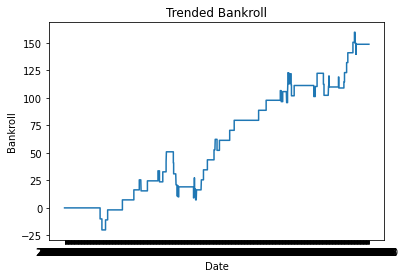

In [28]:
#evaluate model with tuned hyperparameters
xgb_tuned = XGBRegressor(eta=best_params['eta'],
                        gamma=best_params['gamma'],
                        max_depth=int(best_params['max_depth']),
                        min_child_weight=best_params['min_child_weight'])
xgb_tuned.fit(X_train_pca, y_train_pca)
eval_winnings(xgb_tuned, X_test_pca, test_ids_set, confidence_threshold=20, bet_amt=10)

Here, we can see that we were able to beat the performance of the linear regression models after tuning the XGBoost model.  This will function as our final model for future predictions.

In [31]:
#pickle final, tuned model
pickle.dump(xgb_tuned, open('model.pkl', 'wb'))